Obtain Johns Hopkins University CSSE COVID data from BigQuery and transform and enhance it for plotting.  Write the result back to BigQuery as a table.

Based on the excellent tutorials here:

- https://towardsdatascience.com/covid-19-data-processing-58aaa3663f6
- https://googleapis.dev/python/bigquery/latest/usage/pandas.html

In [19]:
import pandas as pd
import numpy as np
import datetime
import pytz

import google.auth
from google.cloud import bigquery
from google.cloud import bigquery_storage
import google.cloud.bigquery.magics

# use BigQuery Storage API by default in BigQuery queries
google.cloud.bigquery.magics.context.use_bqstorage_api = True

In [20]:
# Explicitly create a credentials object. This allows you to use the same
# credentials for both the BigQuery and BigQuery Storage clients, avoiding
# unnecessary API calls to fetch duplicate authentication tokens.
credentials, your_project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

# Make clients.
bqclient = bigquery.Client(credentials=credentials, project=your_project_id,)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

In [21]:
query_string = """
    SELECT *
    FROM `bigquery-public-data.covid19_jhu_csse.confirmed_cases`
    ORDER BY country_region
"""

cases_df = (
    bqclient.query(query_string)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)
#print(cases_df.head())
cases_df = cases_df.drop(columns=['latitude', 'longitude', 'location_geom'])
#print(cases_df.columns)

query_string = """
    SELECT *
    FROM `bigquery-public-data.covid19_jhu_csse.deaths`
    ORDER BY country_region
"""

deaths_df = (
    bqclient.query(query_string)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)
#print(deaths_df.head())
deaths_df = deaths_df.drop(columns=['latitude', 'longitude', 'location_geom'])
#print(deaths_df.columns)

# replace both dataframe's columns with reformatted dates

# Fix the date formatting in the column headers
cols = cases_df.columns
new_cols = ['Province/State', 'Country']
for col in cols:
    if col.startswith('_'):
        # original format is _MM_DD_YY, desired format  is MM/DD/YY
        new_col = col.replace('_', '/')[1:]
        new_cols.append(new_col)  

cases_df.columns = new_cols
deaths_df.columns = new_cols

#print(cases_df.head())
#print(deaths_df.head())

In [22]:
#Transpose
dates = cases_df.columns[3:]

cases_df_long = cases_df.melt(
    id_vars=['Province/State', 'Country'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Cases'
)

deaths_df_long = deaths_df.melt(
    id_vars=['Province/State', 'Country'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Deaths'
)

# Merging cases_df_long and deaths_df_long
full_table = cases_df_long.merge(
  right=deaths_df_long, 
  how='left',
  on=['Province/State', 'Country', 'Date']
)

# convert Date column from string to Date format
full_table['Date'] = pd.to_datetime(full_table['Date'])


# get rid of the rows pertaining to cruise ships
ship_rows = full_table['Province/State'].str.contains('Grand Princess') | \
    full_table['Province/State'].str.contains('Diamond Princess') | \
    full_table['Country'].str.contains('Diamond Princess') | \
    full_table['Country'].str.contains('MS Zaandam')
    
full_table = full_table[~(ship_rows)]

#print(full_table.head())

Next, let’s aggregate data into Country/Region wise and group them by Date and Country/Region.

In [23]:
full_grouped = full_table.groupby(['Date', 'Country'])[['Cases', 'Deaths']].sum().reset_index()

Now add day-wise Daily Cases and Daily Deaths by deducting the corresponding accumulative data on the previous day.

In [24]:
# new cases 
temp = full_grouped.groupby(['Country', 'Date', ])[['Cases', 'Deaths']]

temp = temp.sum().diff().reset_index()

mask = temp['Country'] != temp['Country'].shift(1)

temp.loc[mask, 'Cases'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan

# renaming columns
temp.columns = ['Country', 'Date', 'DailyCases', 'DailyDeaths']

# merging new values
full_grouped = pd.merge(full_grouped, temp, on=['Country', 'Date'])

# filling na with 0
full_grouped = full_grouped.fillna(0)

# fixing data types
cols = ['DailyCases', 'DailyDeaths']
full_grouped[cols] = full_grouped[cols].astype('int')

# 
full_grouped['DailyCases'] = full_grouped['DailyCases'].apply(lambda x: 0 if x<0 else x)
full_grouped['DailyDeaths'] = full_grouped['DailyDeaths'].apply(lambda x: 0 if x<0 else x)

#print(full_grouped.tail())

Now compute the 14-day moving average for each jurisdiction

In [25]:
new_column = full_grouped.groupby('Country').rolling(14)['DailyCases'].mean().round(0)
full_grouped['Cases14davg'] = new_column.reset_index(level=0, drop=True)

new_column = full_grouped.groupby('Country').rolling(14)['DailyDeaths'].mean().round(0)
full_grouped['Deaths14davg'] = new_column.reset_index(level=0, drop=True)

#full_grouped.tail()

In [26]:
full_grouped[full_grouped.Country=='Canada'].tail(n=40)
full_grouped.info

<bound method DataFrame.info of             Date             Country   Cases  Deaths  DailyCases  DailyDeaths  \
0     2020-01-23         Afghanistan       0       0           0            0   
1     2020-01-23             Albania       0       0           0            0   
2     2020-01-23             Algeria       0       0           0            0   
3     2020-01-23             Andorra       0       0           0            0   
4     2020-01-23              Angola       0       0           0            0   
...          ...                 ...     ...     ...         ...          ...   
61987 2020-12-15             Vietnam    1405      35           3            0   
61988 2020-12-15  West Bank and Gaza  113409    1023        2307           23   
61989 2020-12-15               Yemen    2085     606           1            0   
61990 2020-12-15              Zambia   18428     368         106            1   
61991 2020-12-15            Zimbabwe   11522     310         164            1

Write the dataframe to a BigQuery table

In [27]:
job_config = bigquery.LoadJobConfig(
    # Specify a (partial) schema. All columns are always written to the
    # table. The schema is used to assist in data type definitions.
    schema=[
        # Specify the type of columns whose type cannot be auto-detected. For
        # example the "title" column uses pandas dtype "object", so its
        # data type is ambiguous.
        bigquery.SchemaField("Date", bigquery.enums.SqlTypeNames.DATE),
        bigquery.SchemaField("Country", bigquery.enums.SqlTypeNames.STRING),
    ],
    # Optionally, set the write disposition. BigQuery appends loaded rows
    # to an existing table by default, but with WRITE_TRUNCATE write
    # disposition it replaces the table with the loaded data.
    write_disposition="WRITE_TRUNCATE",
)

table_id = "covid-19-plotting-298623.covid_plotting_dataset.csse_countries"

# Make an API request.
job = bqclient.load_table_from_dataframe(full_grouped, table_id, job_config=job_config)  

# Wait for the job to complete.
job.result()

table = bqclient.get_table(table_id)  # Make an API request.
print(
    "Loaded {} rows and {} columns to {}".format(
        table.num_rows, len(table.schema), table_id
    )
)

Loaded 61992 rows and 8 columns to covid-19-plotting-298623.covid_plotting_dataset.csse_countries


TypeError: invalid type promotion

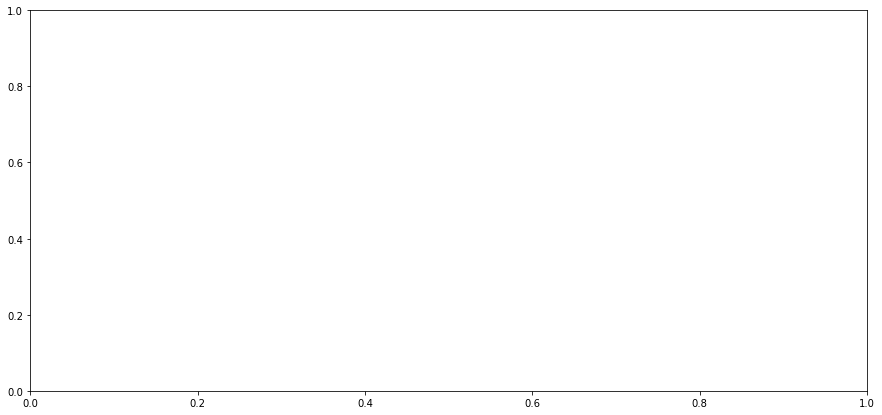

In [40]:
full_grouped.dtypes
full_grouped[full_grouped.Country=='Canada'].plot(kind="bar", stacked=True, figsize=(15, 7))